# 描述性统计
此模块目的在于对竞赛下发的数据集进行描述性统计。

In [1]:
import os
import pandas as pd

train_ori_dir = 'data/images/training_ori/'
train_dir = 'data/images/training/'
test_dir = 'data/images/testB3/'

impost = {'f': '.jpg', 'l': '.png'}
trainfiles = [_.split('.')[0] for _ in os.listdir(train_ori_dir)]
testfiles = [_.split('.')[0] for _ in os.listdir(test_dir)]
trainmeta = pd.DataFrame({'id': trainfiles}).sort_values('id').reset_index(drop=True)
testmeta = pd.DataFrame({'id': testfiles}).sort_values('id').reset_index(drop=True)
trainmeta.head()

,id
0,1000201
1,1000202
2,1000203
3,1000204
4,1000205


样本量非常少

In [2]:
print("训练集: ", trainmeta.shape)
print("测试集: ", testmeta.shape)

训练集:  (4470, 1)
测试集:  (800, 1)


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
trainmeta.head(2)
testmeta.head(2)

,id
0,000001
1,000006


## 接下来按照测试集的格式对训练集做转化

In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
def concat_duijiao(img1, img2):
    half_width = 100
    half_height = 100
    width = 200
    height = 200
    top_left = img1.crop((0, 0, half_width, half_height))
    bottom_right = img1.crop((half_width, half_height, width, height))
    top_right = img2.crop((half_width, 0, width, half_height))
    bottom_left = img2.crop((0, half_height, half_width, height))
    new_image = Image.new("RGB", (width, height))

    # 粘贴裁剪后的区域到新图像
    new_image.paste(top_left, (0, 0))
    new_image.paste(top_right, (half_width, 0))
    new_image.paste(bottom_left, (0, half_height))
    new_image.paste(bottom_right, (half_width, half_height))
    return new_image

def concat_shangxia(img1, img2):
    half_width = 100
    half_height = 100
    width = 200
    height = 200
    new_image = Image.new("RGB", (width, height))
    new_image.paste(img1, (0, 0))
    new_image.paste(img2, (0, half_height))
    return new_image

def concat_zuoyou(img1, img2):
    half_width = 100
    half_height = 100
    width = 200
    height = 200
    new_image = Image.new("RGB", (width, height))
    new_image.paste(img1, (0, 0))
    new_image.paste(img2, (half_width, 0))
    return new_image

In [52]:
import random 
train_ori_gt_dir = 'data/annotations/training_ori/'
train_gt_dir = 'data/annotations/training/'

def concat_images(img1_name):
    img1 = Image.open(train_ori_dir + img1_name + impost['f'])
    img2_name = random.choice(trainmeta['id'])
    img2 = Image.open(train_ori_dir + img2_name + impost['f'])
    img1_gt = Image.open(train_ori_gt_dir + img1_name + impost['l'])
    img2_gt = Image.open(train_ori_gt_dir + img2_name + impost['l'])

    new_image = concat_duijiao(img1, img2)
    new_image_gt = concat_duijiao(img1_gt, img2_gt)

    new_image.save(train_dir + '0' + img1_name + '.jpg')
    new_image_gt.save(train_gt_dir + '0' + img1_name + '.png')

In [53]:
def concat_images_double(img1_name):
    img1 = Image.open(train_ori_dir + img1_name + impost['f'])
    im2_name = random.choice(trainmeta['id'])
    img2 = Image.open(train_ori_dir + im2_name + impost['f'])
    img1_gt = Image.open(train_ori_gt_dir + img1_name + impost['l'])
    img2_gt = Image.open(train_ori_gt_dir + im2_name + impost['l'])

    half_width = 100
    half_height = 100
    width = 200
    height = 200
    if random.random() > 0.5:
        # 上下拼接
        new_image = concat_shangxia(img1, img2)
        new_image_gt = concat_shangxia(img1_gt, img2_gt)
        new_image.save(train_dir + '1' + img1_name + '.jpg')
        new_image_gt.save(train_gt_dir + '1' + img1_name + '.png')
    else:
        # 左右拼接
        new_image = concat_zuoyou(img1, img2)
        new_image_gt = concat_zuoyou(img1_gt, img2_gt)
        new_image.save(train_dir + '2' + img1_name + '.jpg')
        new_image_gt.save(train_gt_dir + '2' + img1_name + '.png')


In [54]:
trainmeta['id'].apply(concat_images)
trainmeta['id'].apply(concat_images_double)

0       None
1       None
2       None
3       None
4       None
        ... 
4465    None
4466    None
4467    None
4468    None
4469    None
Name: id, Length: 4470, dtype: object

0       None
1       None
2       None
3       None
4       None
        ... 
4465    None
4466    None
4467    None
4468    None
4469    None
Name: id, Length: 4470, dtype: object

In [2]:
new_csv = os.listdir('data/images/training')

In [3]:
new_csv = [x.split('.')[0] for x in new_csv]
train_new_meta = pd.DataFrame({'id':new_csv})
train_new_meta.head()

,id
0,11002576
1,21002029
2,11001923
3,01001032
4,02000039


In [4]:
train_new_meta.to_csv('stats/train-meta.csv', index=False)

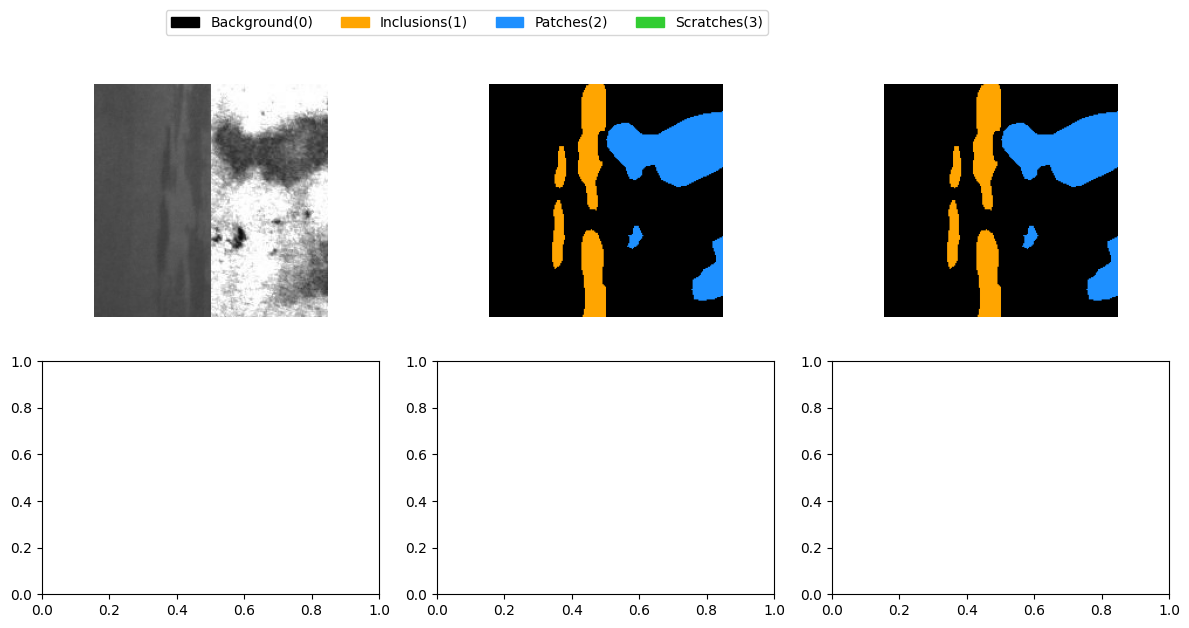

In [50]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from torchvision import transforms
import matplotlib.patches as mpatches
import numpy as np

image_transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

color_map = {
    0: [0, 0, 0],      # Background (黑色)
    1: [255, 165, 0],     # Inclusions (浅橙色)
    2: [30, 144, 255],    # Patches (天蓝色)
    3: [50, 205, 50],     # Scratches (亮绿色)
}
legend_patches = [
    mpatches.Patch(color=np.array(color_map[0])/255, label='Background(0)'),
    mpatches.Patch(color=np.array(color_map[1])/255, label='Inclusions(1)'),
    mpatches.Patch(color=np.array(color_map[2])/255, label='Patches(2)'),
    mpatches.Patch(color=np.array(color_map[3])/255, label='Scratches(3)'),
]

def to_rgb_im(mask):
    height, width = mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    for class_idx, color in color_map.items():
        rgb_image[mask == class_idx] = color
    return rgb_image


a, b = concat_images_double(trainmeta['id'][0])



def plot_result(axes):
    """
        总共绘制3张图, 第一张是原图, 第二张是预测的掩码图, 第三张是GT
        args:
            imid: 希望可视化的图片的id
            train: True: 可视化训练集图片  False: 可视化测试集图片
    """
    imdata = np.array(a)
    mask = np.array(b)[:, :, 0]
    pred = np.array(b)[:, :, 0]


    # 颜色转换
    mask, pred = to_rgb_im(mask), to_rgb_im(pred)

    axes[0].imshow(imdata)
    axes[0].axis('off')
    axes[1].imshow(mask) 
    axes[1].axis('off') 
    axes[2].imshow(pred) 
    axes[2].axis('off') 
fig, axes = plt.subplots(2, 3, figsize=(12, 6)) 
fig.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(0.65, 1.05), ncol=4)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plot_result(axes[0])

In [11]:
trainmeta['id'].apply(concat_images)

0       None
1       None
2       None
3       None
4       None
        ... 
4465    None
4466    None
4467    None
4468    None
4469    None
Name: id, Length: 4470, dtype: object

In [12]:
make_files = [_.split('.')[0] for _ in os.listdir(train_dir)]
train_new_meta = pd.DataFrame({'id': make_files}).sort_values('id').reset_index(drop=True)
train_new_meta.head()

,id
0,1000201
1,1000202
2,1000203
3,1000204
4,1000205


In [13]:
train_new_meta.to_csv('stats/train-meta.csv', index=False)
testmeta.to_csv('stats/test-meta.csv', index=False)